In [29]:
import os
import glob
import re
import itertools

import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation

In [30]:
data = pd.read_parquet('/cephfs/users/annawoodard/gene-fusion/data/processed/fusions.parquet')
#data = pd.read_parquet('/cephfs/users/annawoodard/gene-fusion/fusion_union.parquet')

In [31]:
subtypes = pd.read_csv('/cephfs/users/annawoodard/gene-fusion/data/external/Perou_Nigeria_109_samples_PAM50_Calls_9-12-19_UPDATED_9-21-19-PSR.csv')

dupe_samples = [
    'LIB-04604wt',
    'LIB-04626wt',
    'LIB-04662wt',
    'LIB-04629wt',
    'LIB-04609wt',
    'LIB-04660wt',
    'LIB-04623wt',
    'LIB-04607wt',
    'LIB-04630wt',
    'LIB-04622wt',
    'LIB-03328WT',
    'LIB-04661wt',
    'LIB-04588wt'
]

subtypes = subtypes.loc[~subtypes['RNAseq_name'].str.contains('|'.join(dupe_samples))]
subtypes['RNAseq_name'].nunique()

96

In [32]:
subtypes[subtypes['SUBTYPE_Zhao_4'] == 'Basal']['RNAseq_name'].nunique()

41

minimum FFPM: nan


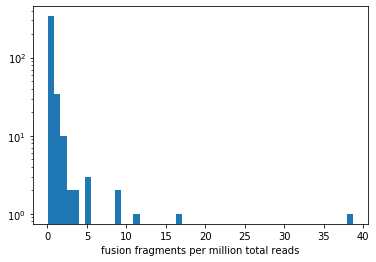

In [33]:
ax = data['FFPM'].hist(bins=50)
ax.set_yscale('log')
ax.grid(False)
ax.set_xlabel('fusion fragments per million total reads')
print('minimum FFPM: {:.1f}'.format(min(data['FFPM'])))

From the STAR-fusion documentation: a filter of 0.1 sum FFPM (meaning at least 1 fusion-supporting rna-seq fragment per 10M total reads) tends to be effective at excluding fusion artifacts. I've required FFPM >= 0.1 here.

Text(0.5, 0, 'Shannon entropy (left breakpoint)')

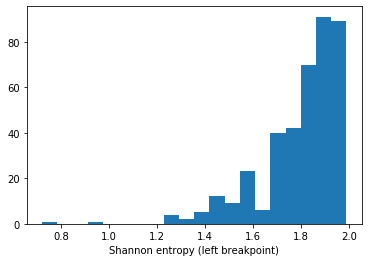

In [6]:
ax = data['LeftBreakEntropy'].hist(bins=20)
ax.grid(False)
ax.set_xlabel('Shannon entropy (left breakpoint)')

Text(0.5, 0, 'Shannon entropy (right breakpoint)')

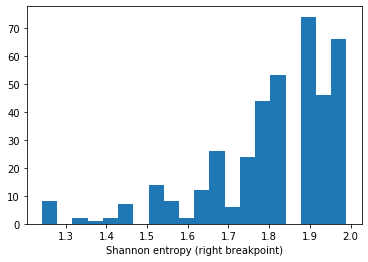

In [7]:
ax = data['RightBreakEntropy'].hist(bins=20)
ax.grid(False)
ax.set_xlabel('Shannon entropy (right breakpoint)')

Above: the Shannon entropy of the 15 exonic bases flanking the breakpoint. From the STAR-fusion documentation: the maximum entropy is 2, representing highest complexity. The lowest would be zero (involving a 15 base mononucleotide run). Low entropy sites should generally be treated as less confident breakpoints.

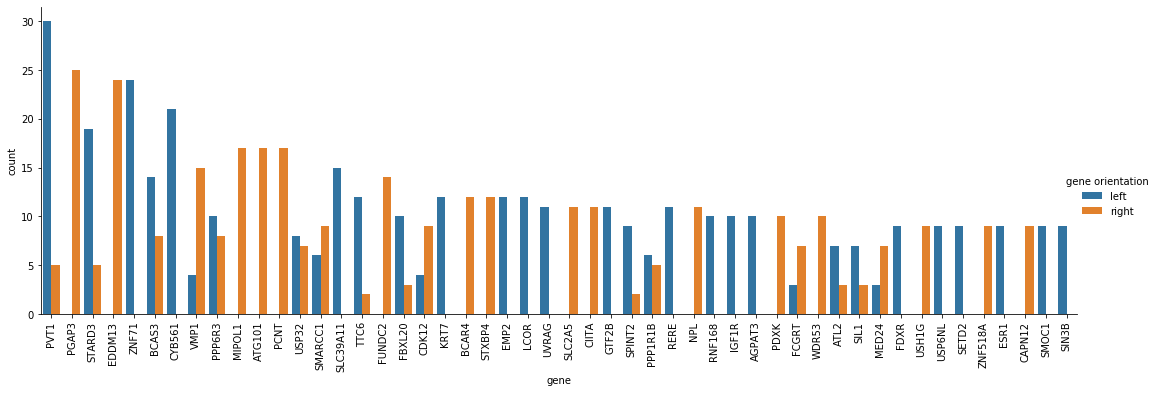

In [8]:
melted_data = pd.melt(data[['gene1', 'gene2']])
order = melted_data.value.value_counts().keys().to_list()
g = sns.catplot(x="value", kind="count", hue="variable", data=melted_data, order=order[:50], aspect=3, legend_out=True)
g.set_xticklabels(rotation=90)
g.axes[0,0].set_xlabel('gene')
g._legend.set_title('gene orientation')
g._legend.texts[0].set_text('left')
g._legend.texts[1].set_text('right')

In [9]:
oncokb = pd.read_table('/cephfs/users/annawoodard/gene-fusion/allActionableVariants.txt')
fusion_oncokb = oncokb.loc[oncokb.Alteration.str.contains('Fusion')]

In [10]:
fusion_oncokb

,Isoform,RefSeq,Entrez Gene ID,Hugo Symbol,Alteration,Protein Change,Cancer Type,Level,Drugs(s),PMIDs for drug,Abstracts for drug
7,ENST00000318560,NM_005157.4,25,ABL1,BCR-ABL1 Fusion,BCR-ABL1 Fusion,B-Lymphoblastic Leukemia/Lymphoma,1,"Dasatinib, Imatinib, Ponatinib","11287973, 12200353, 17496201, 20131302, 219311...",Hunger et al. ASH 2017 http://www.bloodjournal...
9,ENST00000318560,NM_005157.4,25,ABL1,BCR-ABL1 Fusion,BCR-ABL1 Fusion,Chronic Myelogenous Leukemia,1,"Bosutinib, Dasatinib, Imatinib, Nilotinib","11287972, 11287973, 12637609, 20525993, 205259...",NaN
11,ENST00000389048,NM_004304.4,238,ALK,Fusions,Fusions,Non-Small Cell Lung Cancer,1,"Alectinib, Ceritinib, Crizotinib","23724913, 28126333, 28586279, 29596029, 296688...",NaN
39,ENST00000358487,NM_000141.4,2263,FGFR2,Fusions,Fusions,Bladder Cancer,1,Erdafitinib,"26324363, 31340094",NaN
40,ENST00000260795,NM_000142.4,2261,FGFR3,Fusions,Fusions,Bladder Cancer,1,Erdafitinib,"26324363, 31340094",NaN
54,ENST00000524377,NM_002529.3,4914,NTRK1,Fusions,Fusions,All Solid Tumors,1,Larotrectinib,"26216294, 29466156",NaN
55,ENST00000277120,NM_006180.3,4915,NTRK2,Fusions,Fusions,All Solid Tumors,1,Larotrectinib,"26216294, 29466156",NaN
56,ENST00000360948,NM_001012338.2,4916,NTRK3,Fusions,Fusions,All Solid Tumors,1,Larotrectinib,"26216294, 29466156",NaN
59,ENST00000331163,NM_002608.2,5155,PDGFB,COL1A1-PDGFB Fusion,COL1A1-PDGFB Fusion,Dermatofibrosarcoma Protuberans,1,Imatinib,"15503291, 15681532, 15746584, 18451237, 196205...",NaN
60,ENST00000257290,NM_006206.4,5156,PDGFRA,FIP1L1-PDGFRA Fusion,FIP1L1-PDGFRA Fusion,"Chronic Eosinophilic Leukemia, NOS",1,Imatinib,18950453,NaN


In [11]:
data[(data.gene1.isin(fusion_oncokb['Hugo Symbol'])) | (data.gene2.isin(fusion_oncokb['Hugo Symbol']))]['name'].unique()

array(['ETV6--NTRK3', 'ABL1--BCR', 'JAK2--RP11-399D6.2'], dtype=object)

In [12]:
fusion_oncokb[(fusion_oncokb['Hugo Symbol'].isin(data.gene1)) | (fusion_oncokb['Hugo Symbol'].isin(data.gene2))]

,Isoform,RefSeq,Entrez Gene ID,Hugo Symbol,Alteration,Protein Change,Cancer Type,Level,Drugs(s),PMIDs for drug,Abstracts for drug
7,ENST00000318560,NM_005157.4,25,ABL1,BCR-ABL1 Fusion,BCR-ABL1 Fusion,B-Lymphoblastic Leukemia/Lymphoma,1,"Dasatinib, Imatinib, Ponatinib","11287973, 12200353, 17496201, 20131302, 219311...",Hunger et al. ASH 2017 http://www.bloodjournal...
9,ENST00000318560,NM_005157.4,25,ABL1,BCR-ABL1 Fusion,BCR-ABL1 Fusion,Chronic Myelogenous Leukemia,1,"Bosutinib, Dasatinib, Imatinib, Nilotinib","11287972, 11287973, 12637609, 20525993, 205259...",NaN
56,ENST00000360948,NM_001012338.2,4916,NTRK3,Fusions,Fusions,All Solid Tumors,1,Larotrectinib,"26216294, 29466156",NaN
67,ENST00000318560,NM_005157.4,25,ABL1,BCR-ABL1 Fusion,BCR-ABL1 Fusion,B-Lymphoblastic Leukemia/Lymphoma,2A,"Bosutinib, Nilotinib","15071128, 19075254",NaN
130,ENST00000318560,NM_005157.4,25,ABL1,BCR-ABL1 Fusion,BCR-ABL1 Fusion,Chronic Myelogenous Leukemia,3A,Asciminib,NaN,"Mauro, M. et al. Abstract# TPS7081, ASCO 2018 ..."
161,ENST00000381652,NM_004972.3,3717,JAK2,PCM1-JAK2 Fusion,PCM1-JAK2 Fusion,"Chronic Eosinophilic Leukemia, NOS",3A,Ruxolitinib,"22875628, 22899477, 23400675, 23630205, 252077...",NaN
189,ENST00000360948,NM_001012338.2,4916,NTRK3,Fusions,Fusions,All Solid Tumors,3A,Entrectinib,28183697,"Demetri et al. Abstract# LBA17, ESMO 2018 Cong..."


In [13]:
for fusion in ['ETV6--NTRK3', 'BCR--ABL1', 'JAK2--RP11-399D6.2', 'BRAF--ADCK2', 'PDGFRB--PFDN5']:
    print(data.loc[data.name == fusion, 'patient'].unique())

['L000160']
[]
['N010870']
[]
[]


In [14]:
ihc = pd.read_csv('/cephfs/users/annawoodard/gene-fusion/WABCS_final_IHC_2019-06-14.csv', dtype=str)

In [15]:
ihc.columns

Index(['NBCS Barcode', 'WES', 'RNA-seq', 'WGS', 'ER Status', 'ER Allred Score',
       'ER intensity', 'ER % Score', 'PR Status', 'PR Allred Score',
       'PR intensity', 'PR % Score', 'HER2 Status by IHC', 'HER2IHCScore',
       'HER2intensity', 'HER2%Score', 'HER2 amplified', 'focal',
       'copy number (adj. purity/ploidy)', 'Ploidy17p', 'Ploidy17q',
       'CN/ploidy17p ratio', 'CN/ploidy17q ratio', 'Final HR status',
       'Final HER2 Status', 'Unnamed: 25', 'NBCS Barcode.1', 'ER Status.1',
       'ER Allred Score.1', 'ER intensity.1', 'ER % score', 'PR Status.1',
       'PR Allred Score.1', 'PR intensity.1', 'PR % score', 'HER2 Status',
       'HER2 Score', 'HER2 % score', 'ER Status.2', 'ER Allred Score.2',
       'ER intensity.2', 'ER % Score.1', 'PR Status.2', 'PR Allred Score.2',
       'PR intensity.2', 'PR % Score.1', 'HER2 Status.1', 'HER2 IHC Score',
       'HER2 intensity', 'HER2 % Score', 'Unnamed: 50', 'Unnamed: 51',
       'NBCS Barcode.2', 'Collection Site', 'Date

In [16]:
sample_info

NameError: name 'sample_info' is not defined

In [ ]:
id_map = pd.read_csv('/cephfs/users/annawoodard/gene-fusion/WABCS-U01_Samples_Phenotype_master2B.csv')
samples = subtypes['RNAseq_name'].unique()
patients = [id_map[id_map['NGDx RNAseq Lib ID'] == s[:-2]]['NBCS barcode'].iloc[0] for s in samples]
sample_info = pd.read_csv('/cephfs/users/annawoodard/gene-fusion/data/external/sample_info_JB.csv')
#samples = sample_info['sample_name'].unique()
#patients = [sample_info[sample_info['sample_name'] == s]['patient_ID'].iloc[0] for s in samples]


fusion_counts = pd.DataFrame(data={
    'patient': patients,
    'fusions per sample': [data[data['sample'] == s]['name'].nunique() for s in samples],
    'ER Status': [subtypes[subtypes['RNAseq_name'] == s]['ER_status'].iloc[0] for s in samples],
    'PR Status': [subtypes[subtypes['RNAseq_name'] == s]['PR_status'].iloc[0] for s in samples],
    'HER2 Status': [subtypes[subtypes['RNAseq_name'] == s]['HER2_status'].iloc[0] for s in samples]
    }
)

In [ ]:
print('mean fusions per tumor: {:.1f} +/- {:.1f}'.format(
    fusion_counts['fusions per sample'].mean(),
    fusion_counts['fusions per sample'].std()
    )
)

In [ ]:
fusion_counts[fusion_counts['fusions per sample'] == 0]

In [ ]:
order = ['HER2+', 'HER2-']
ax = sns.boxplot(x='HER2 Status', y='fusions per sample', data=fusion_counts, order=order)
test_results = add_stat_annotation(ax, data=fusion_counts, x='HER2 Status', y='fusions per sample', order=order,
                                   box_pairs=[("HER2+", "HER2-")],
                                   test='Mann-Whitney', text_format='star', verbose=2)

In [ ]:
order = ['ER+', 'ER-']
ax = sns.boxplot(x='ER Status', y='fusions per sample', data=fusion_counts)
test_results = add_stat_annotation(ax, data=fusion_counts, x='ER Status', y='fusions per sample', order=order,
                                   box_pairs=[("ER+", "ER-")],
                                   test='Mann-Whitney', text_format='star', verbose=2)

In [ ]:
order = ['PR+', 'PR-']
ax = sns.boxplot(x='PR Status', y='fusions per sample', data=fusion_counts)
test_results = add_stat_annotation(ax, data=fusion_counts, x='PR Status', y='fusions per sample', order=order,
                                   box_pairs=[("PR+", "PR-")],
                                   test='Mann-Whitney', text_format='star', verbose=2)

In [ ]:
subtype = []
hr_subtype = []
rebinned_hr_subtype = []
pam50_naturecomm = []
age = []
for s in samples:
    subtype += [
        '{}/{}/{}'.format(
            subtypes[subtypes['RNAseq_name'] == s]['ER_status'].iloc[0],
            subtypes[subtypes['RNAseq_name'] == s]['PR_status'].iloc[0],
            subtypes[subtypes['RNAseq_name'] == s]['HER2_status'].iloc[0]
        )
    ]
    er_pos = (subtypes[subtypes['RNAseq_name'] == s]['ER_status'].iloc[0] == 'ER+')
    pr_pos = (subtypes[subtypes['RNAseq_name'] == s]['PR_status'].iloc[0] == 'PR+')
    her2_status = subtypes[subtypes['RNAseq_name'] == s]['HER2_status'].iloc[0]
    hr_subtype += [
        '{}/{}'.format(
            'HR+' if (er_pos or pr_pos) else 'HR-',
            her2_status
        )
    ]
    rebinned_hr_subtype += [
        her2_status if her2_status == 'HER2+' else '{}/HER2-'.format('HR+' if (er_pos or pr_pos) else 'HR-')
    ]
    pam50_naturecomm += [sample_info[sample_info['sample_name'] == s[:-2]]['subtype_NatureComm'].iloc[0]]
for p in patients:
    age += [ihc.loc[ihc['NBCS Barcode'] == p, 'Age'].astype(int).iloc[0]]

fusion_counts = pd.DataFrame(data={
    'patient': patients,
    'fusions per sample': [data[data['sample'] == s]['name'].nunique() for s in samples],
    'subtype': subtype,
    'hr_subtype': hr_subtype,
    'rebinned_hr_subtype': rebinned_hr_subtype,
    'pam50_naturecomm': pam50_naturecomm,
    'age': age
    }
)


In [ ]:
sns.lmplot(x="age", y="fusions per sample", data=fusion_counts)
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(fusion_counts['age'], fusion_counts['fusions per sample'])
print(slope, intercept, r_value, p_value, std_err)

In [ ]:
subtypes.SUBTYPE_Zhao_4.unique()

In [ ]:
order = ['Her2', 'LumB', 'Basal', 'LumA', 'Normal']
box_pairs = [('Basal', 'Normal'), ('LumB', 'Normal'), ('Her2', 'Normal'), ('LumA', 'Normal')]
ax = sns.boxplot(x='pam50_naturecomm', y='fusions per sample', data=fusion_counts, order=order)
test_results = add_stat_annotation(ax, data=fusion_counts, x='pam50_naturecomm', y='fusions per sample', order=order,
                                   #box_pairs=itertools.combinations(order, 2),
                                   box_pairs=box_pairs,
                                   test='Mann-Whitney', text_format='star', verbose=2)
for l in ax.get_xticklabels():
    l.set_rotation(90)

In [ ]:
summary = pd.DataFrame(data={
    'subtype': order,
    'mean fusion load': [
        '{:.1f} +/ {:.1f}'.format(
            fusion_counts.loc[fusion_counts['pam50_naturecomm'] == x, 'fusions per sample'].mean(),
            fusion_counts.loc[fusion_counts['pam50_naturecomm'] == x, 'fusions per sample'].std()
        )
    for x in order],
    'n': [len(fusion_counts.loc[fusion_counts['pam50_naturecomm'] == x]) for x in order]
    }
)
summary

In [ ]:
sum([len(fusion_counts.loc[fusion_counts['class_4_zhao'] == x]) for x in order])

In [ ]:
order = [
    'ER-/PR-/HER2+',
    'ER-/PR-/HER2-',
    'ER+/PR+/HER2+',
    'ER+/PR-/HER2+',
    'ER+/PR+/HER2-',
    'ER-/PR+/HER2-',
    'ER+/PR-/HER2-',
#    'ER-/PR+/HER2+'
]
ax = sns.boxplot(x='subtype', y='fusions per sample', data=fusion_counts, order=order)
test_results = add_stat_annotation(ax, data=fusion_counts, x='subtype', y='fusions per sample', order=order,
                                   box_pairs=itertools.combinations(order, 2),
                                   test='Mann-Whitney', text_format='star', verbose=2)
for l in ax.get_xticklabels():
    l.set_rotation(90)

In [ ]:
fusion_counts.subtype.value_counts()

In [ ]:
order = [
    'HR-/HER2+',
    'HR-/HER2-',
    'HR+/HER2+',
    'HR+/HER2-',
]
ax = sns.boxplot(x='hr_subtype', y='fusions per sample', data=fusion_counts, order=order)
test_results = add_stat_annotation(ax, data=fusion_counts, x='hr_subtype', y='fusions per sample', order=order,
                                   box_pairs=itertools.combinations(order, 2),
                                   test='Mann-Whitney', text_format='star', verbose=2
)
for l in ax.get_xticklabels():
    l.set_rotation(90)

In [ ]:
summary = pd.DataFrame(data={
    'subtype': order,
    'mean fusion load': [
        '{:.1f} +/ {:.1f}'.format(
            fusion_counts.loc[fusion_counts['hr_subtype'] == x, 'fusions per sample'].mean(),
            fusion_counts.loc[fusion_counts['hr_subtype'] == x, 'fusions per sample'].std()
        )
    for x in order],
    'n': [len(fusion_counts.loc[fusion_counts['hr_subtype'] == x]) for x in order]
    }
)
summary

In [ ]:
order = [
    'HER2+',
    'HR-/HER2-',
    'HR+/HER2-',
]
ax = sns.boxplot(x='rebinned_hr_subtype', y='fusions per sample', data=fusion_counts, order=order)
test_results = add_stat_annotation(ax, data=fusion_counts, x='rebinned_hr_subtype', y='fusions per sample', order=order,
                                   box_pairs=itertools.combinations(order, 2),
                                   test='Mann-Whitney', text_format='star', verbose=2
)
for l in ax.get_xticklabels():
    l.set_rotation(90)

In [17]:
summary = pd.DataFrame(data={
    'subtype': order,
    'mean fusion load': [
        '{:.1f} +/ {:.1f}'.format(
            fusion_counts.loc[fusion_counts['rebinned_hr_subtype'] == x, 'fusions per sample'].mean(),
            fusion_counts.loc[fusion_counts['rebinned_hr_subtype'] == x, 'fusions per sample'].std()
        )
    for x in order],
    'n': [len(fusion_counts.loc[fusion_counts['rebinned_hr_subtype'] == x]) for x in order]
    }
)
summary

NameError: name 'fusion_counts' is not defined

In [18]:
labels = ['ER-', 'ER+', 'PR-', 'PR+', 'HER2-', 'HER2+']

In [19]:
list(itertools.combinations(labels, 3))

[('ER-', 'ER+', 'PR-'),
 ('ER-', 'ER+', 'PR+'),
 ('ER-', 'ER+', 'HER2-'),
 ('ER-', 'ER+', 'HER2+'),
 ('ER-', 'PR-', 'PR+'),
 ('ER-', 'PR-', 'HER2-'),
 ('ER-', 'PR-', 'HER2+'),
 ('ER-', 'PR+', 'HER2-'),
 ('ER-', 'PR+', 'HER2+'),
 ('ER-', 'HER2-', 'HER2+'),
 ('ER+', 'PR-', 'PR+'),
 ('ER+', 'PR-', 'HER2-'),
 ('ER+', 'PR-', 'HER2+'),
 ('ER+', 'PR+', 'HER2-'),
 ('ER+', 'PR+', 'HER2+'),
 ('ER+', 'HER2-', 'HER2+'),
 ('PR-', 'PR+', 'HER2-'),
 ('PR-', 'PR+', 'HER2+'),
 ('PR-', 'HER2-', 'HER2+'),
 ('PR+', 'HER2-', 'HER2+')]

In [20]:
order = [
    'HER2+_ER-',
    'TNBC',
    'HER2+_ER+',
    'ER-_HER2-_PR+',
]
ax = sns.boxplot(x='class_4_zhao', y='fusions per sample', data=fusion_counts, order=order)
test_results = add_stat_annotation(ax, data=fusion_counts, x='class_4_zhao', y='fusions per sample', order=order,
                                   box_pairs=itertools.combinations(order, 2),
                                   test='Mann-Whitney', text_format='star', verbose=2
)
for l in ax.get_xticklabels():
    l.set_rotation(90)

NameError: name 'fusion_counts' is not defined

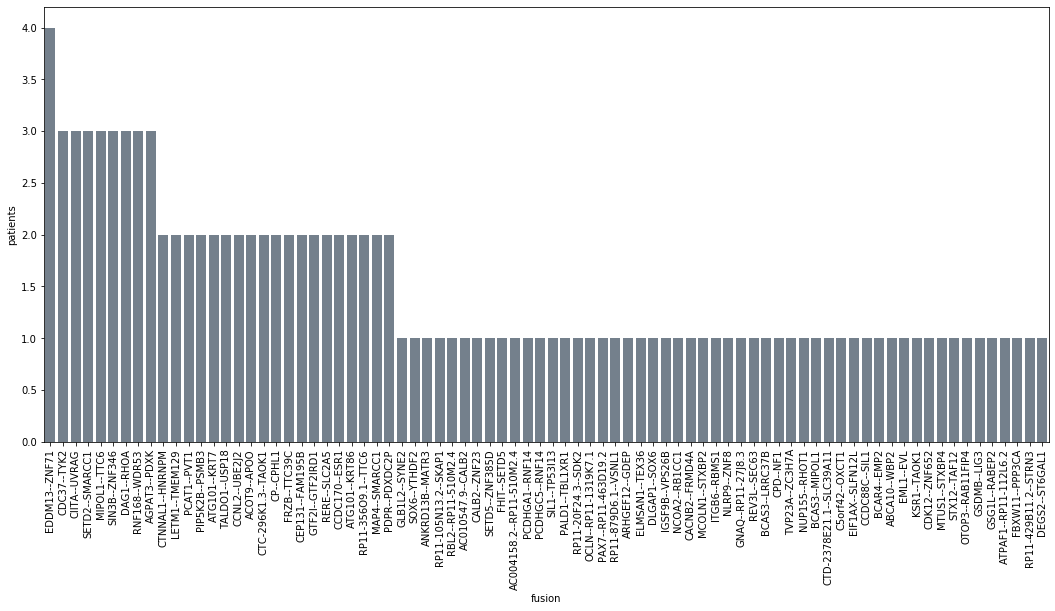

In [21]:
fusions = data['name'].unique()
patient_counts = pd.DataFrame(data={
    'fusion': fusions,
    'count': [len(data[data['name'] == fusion]['patient'].unique()) for fusion in fusions]
    }
)
order = patient_counts.sort_values(['count'], ascending=False)['fusion']
fg = plt.figure(figsize=(18, 8))
ax = sns.barplot(x='fusion', y='count', data=patient_counts, color='slategrey', order=order[:80])
ax.set_ylabel('patients')
for l in ax.get_xticklabels():
    l.set_rotation(90)

In [220]:
data[data.name.str.contains('ZNF71')]['annotations'].tolist()
'{:.1f}%patient_counts[patient_counts.fusion == 'EDDM13--ZNF71']['count'].iloc[0] / len(patients)

0.041666666666666664

In [229]:
print('most common fusion is {} which appears in {:.1f}% ({}/{}) of samples'.format(
    patient_counts.sort_values(['count'], ascending=False).iloc[0].fusion,
    patient_counts.sort_values(['count'], ascending=False).iloc[0]['count'] / len(patients) * 100,
    patient_counts.sort_values(['count'], ascending=False).iloc[0]['count'],
    len(patients)
    )
)

most common fusion is EDDM13--ZNF71 which appears in 4.2% (4/96) of samples


In [149]:
patient_counts.loc[patient_counts.fusion.str.contains('ETV6--NTRK3|BCR--ABL1|JAK2--RP11-399D6.2|BRAF--ADCK2|PDGFRB--PFDN5')]

,fusion,count
162,ETV6--NTRK3,1
212,JAK2--RP11-399D6.2,1


In [155]:
'{:.1f}% of fusions in more than one sample; {:.1f}% of fusions in a single sample'.format(
    (len(patient_counts[patient_counts['count'] > 1]) / len(patient_counts)) * 100,
    (len(patient_counts[patient_counts['count'] == 1]) / len(patient_counts)) * 100
)

'3.9% of fusions in more than one sample; 96.1% of fusions in a single sample'

In [108]:
data.loc[data['name'].str.contains('TP53'), ['name', 'arriba', 'starfusion', 'starseqr']]

,name,arriba,starfusion,starseqr
5,SIL1--TP53I13,True,None,None
96,SIL1--TP53I13,None,None,True
2,SIL1--TP53I13,None,True,None


In [34]:
data

,gene1,gene2,strand1(gene/fusion),strand2(gene/fusion),breakpoint1,breakpoint2,site1,site2,type,direction1,direction2,split_reads1,split_reads2,discordant_mates,coverage1,coverage2,confidence,closest_genomic_breakpoint1,closest_genomic_breakpoint2,filters,fusion_transcript,reading_frame,peptide_sequence,read_identifiers,sample,patient,name,junction_reads,spanning_reads,arriba,NAME,NREAD_SPANS,NREAD_JXNLEFT,NREAD_JXNRIGHT,FUSION_CLASS,SPLICE_TYPE,BRKPT_LEFT,BRKPT_RIGHT,LEFT_SYMBOL,RIGHT_SYMBOL,ANNOT_FORMAT,LEFT_ANNOT,RIGHT_ANNOT,DISTANCE,ASSEMBLED_CONTIGS,ASSEMBLY_CROSS_JXN,PRIMERS,ID,SPAN_CROSSHOM_SCORE,JXN_CROSSHOM_SCORE,OVERHANG_DIVERSITY,MINFRAG20,MINFRAG35,OVERHANG_MEANBQ,SPAN_MEANBQ,JXN_MEANBQ,OVERHANG_BQ15,SPAN_BQ15,JXN_BQ15,OVERHANG_MM,SPAN_MM,JXN_MM,OVERHANG_MEANLEN,SPAN_MEANLEN,JXN_MEANLEN,TPM_FUSION,TPM_LEFT,TPM_RIGHT,MAX_TRX_FUSION,DISPOSITION,chromosome1,chromosome2,starseqr,#FusionName,JunctionReadCount,SpanningFragCount,SpliceType,LeftGene,LeftBreakpoint,RightGene,RightBreakpoint,JunctionReads,SpanningFrags,LargeAnchorSupport,FFPM,LeftBreakDinuc,LeftBreakEntropy,RightBreakDinuc,RightBreakEntropy,annots,starfusion,annotations
2,ITGB6,RBMS1,-/-,-/-,2:160169212,2:160303487,splice-site,splice-site,duplication,upstream,downstream,22.0,106.0,65.0,807.0,374.0,high,.,.,"duplicates(95),low_entropy(11),mismappers(1)",AATGACTCCCTCCACCTCCTGGTCTTTGTGAGTGATGCTGATTCTCATTTTGGAATGGACAGCAAACTAGCAGGCATCGTCATTCCTAATGACGGGCTCTGTCACTTGGACAGCAAGAATGAATACTCCATGTCAACTGTCTTG___GAATATCCAACAATTGGACAACTCATTGATAAACTGGTACAAAACAACGTGTTATTGATCTTCGCTGTAACCCAAGAACAAGTTCATTTATATGAG|CAACAGGAACAAGATCCTACCAACCTCTACATTTCTAATTTGCCACTCTCCATGGATGAGCAAGAACTAGAAAATATGCTCAAACCATTTGGACAAGTTATTTCTACAAGGATACTACGTGATTCCAGTGGTACAAGTCGTGGTGTTGGCTTTGCTAG___GATGGAATCAACAGAAAAATGTGAAGCTGTTATTGGTCATTTTAATGGAAAATTTATTAAGACACCACCAGGAGTTTCTG___CCCCCACAGAACCTTTATTGTGTAAGTTTGCTGATGGAGGACAGAAAAAGAGACAGAACCCAAACAAATACATCCCTAATGGAAGACCATG,in-frame,NDSLHLLVFVSDADSHFGMDSKLAGIVIPNDGLCHLDSKNEYSMSTVLEYPTIGQLIDKLVQNNVLLIFAVTQEQVHLYE|QQEQDPTNLYISNLPLSMDEQELENMLKPFGQVISTRILRDSSGTSRGVGFARMESTEKCEAVIGHFNGKFIKTPPGVSAPTEPLLCKFADGGQKKRQNPNKYIPNGRP,.,LIB-03335WT,N010898,ITGB6--RBMS1,128,65,True,None,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,NaN,NaN,None,None,None,None,None,None,None,None,NaN,None,NaN,None,NaN,None,None,"{""ITGB6--RBMS1"":{""LOCALITY"":[""INTRACHROMOSOMAL[chr2:0.07Mb]"",""LOCAL_REARRANGEMENT:-:[71838]""],""CCLE_StarF2019"":""UACC893_BREAST"",""YOSHIHARA_TCGA"":""BLCA:1|BRCA:1"",""TumorFusionsNAR2018"":""BLCA:1.32%|HNSC:0.29%|LUSC:0.25%|BRCA:0.12%"",""TCGA_StarF2019"":""TCGA-BLCA-TP:1.351;n=5|TCGA-HNSC-TP:0.406;n=2|TCGA-LUSC-TP:0.211;n=1|TCGA-BRCA-TP:0.099;n=1|TCGA-BRCA-NT:1.587;n=1"",""Klijn_CellLines"":""{Klijn_CellLines:Breast=1}"",""ATTS"":[""CCLE_StarF2019"",""Klijn_CellLines"",""ChimerSeq"",""TumorFusionsNAR2018"",""YOSHIHARA_TCGA"",""TCGA_StarF2019""]}}"
3,ITGB6,RBMS1,-/-,-/-,2:160172569,2:160303487,splice-site,splice-site,duplication,upstream,downstream,0.0,2.0,11.0,1050.0,374.0,high,.,.,duplicates(5),TGATGCAATTATGCAAGCTGCTGTGTGTAAG___GAAAAAATTGGCTGGCGGAATGACTCCCTCCACCTCCTGGTCTTTGTGAGTGATGCTGATTCTCATTTTGGAATGGACAGCAAACTAGCAGGCATCGTCATTCCTAATGACGGGCTCTGTCACTTGGACAGCAAGAATGAATACTCCATGTCAACTGTCTTG|CAACAGGAACAAGATCCTACCAACCTCTACATTTCTAATTTGCCACTCTCCATGGATGAGCAAGAACTAGAAAATATGCTCAAACCATTTGGACAAGTTATTTCTACAAGGATACTACGTGATTCCAGTGGTACAAGTCGTGGTGTTGGCTTTGCTAG___GATGGAATCAACAGAAAAATGTGAAGCTGTTATTGGTCATTTTAATGGAAAATTTATTAAGACACCACCAGGAGTTTCTG___CCCCCACAGAACCTTTATTGTGTAAGTTTGCTGATGGAGGACAGAAAAAGAGACAGAACCCAAACAAATAC,in-frame,DAIMQAAVCKEKIGWRNDSLHLLVFVSDADSHFGMDSKLAGIVIPNDGLCHLDSKNEYSMSTVL|QQEQDPTNLYISNLPLSMDEQELENMLKPFGQVISTRILRDSSGTSRGVGFARMESTEKCEAVIGHFNGKFIKTPPGVSAPTEPLLCKFADGGQKKRQNPNK,.,LIB-03335WT,N010898,ITGB6--RBMS1,2,11,True,None,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,NaN,NaN,NaN,Na

In [36]:
gao_tcga_calls = pd.read_csv('/cephfs/users/annawoodard/gene-fusion/data/external/final_fusion_call_set.csv', comment='#')
gao_fusions = sorted(data[data['name'].isin(gao_tcga_calls.Fusion)]['name'].unique().tolist())

In [37]:
pd.set_option('max_colwidth', 4000)
cancer_relevant_fusion_dbs = ['Mitelman', 'chimerdb', 'ChimerKB', 'ChimerPub', 'Cosmic', 'YOSHIHARA_TCGA', 'Klijn_CellLines', 'Larsson_TCGA', 'CCLE', 'HaasMedCancer', 'GUO2018CR_TCGA', 'TumorFusionsNAR2018', 'TCGA_StarF2019', 'CCLE_StarF2019']
summary = pd.DataFrame(data={
    'database': cancer_relevant_fusion_dbs + ['Gao_TCGA_2018'],
    'number of unique fusions': [data[data.annotations.str.contains(db)].name.nunique() for db in cancer_relevant_fusion_dbs] + [len(gao_fusions)],
    'unique fusions': [sorted(data[data.annotations.str.contains(db)].name.unique().tolist()) for db in cancer_relevant_fusion_dbs] + [gao_fusions],
    }
)
summary

,database,number of unique fusions,unique fusions
0,Mitelman,0,[]
1,chimerdb,2,"[ABL1--BCR, ETV6--NTRK3]"
2,ChimerKB,2,"[ABL1--BCR, ETV6--NTRK3]"
3,ChimerPub,2,"[ABL1--BCR, ETV6--NTRK3]"
4,Cosmic,1,[ETV6--NTRK3]
5,YOSHIHARA_TCGA,6,"[ABL1--BCR, ARHGEF10L--PADI4, ETV6--NTRK3, ITGB6--RBMS1, OSGIN2--RIPK2, RPS6KB1--VMP1]"
6,Klijn_CellLines,8,"[ABL1--BCR, ACOT9--APOO, CHAF1A--KDM4B, CLTC--VMP1, ITGB6--RBMS1, KIAA1958--SNX30, MAP4--SMARCC1, RPS6KB1--VMP1]"
7,Larsson_TCGA,2,"[CLTC--VMP1, ETV6--NTRK3]"
8,CCLE,14,"[ABL1--BCR, CLTC--VMP1, CTCF--LRRC36, GTF2I--GTF2IRD1, ITGB6--RBMS1, LPP--TPRG1, LY75-CD302--RBMS1, MED16--SBNO2, MIPOL1--TTC6, NIPBL--WDR70, RERE--SLC2A5, RPS6KB1--VMP1, SMYD3--ZNF670-ZNF695, SMYD3--ZNF695]"
9,HaasMedCancer,1,[ETV6--NTRK3]


In [38]:
print('total number of unique fusions reported across all databases: {}'.format(
    len(set(sum(summary['unique fusions'].tolist(), []))))
)

total number of unique fusions reported across all databases: 62


In [40]:
sorted(set(sum(summary['unique fusions'].tolist(), [])))

['ABL1--BCR',
 'ACOT9--APOO',
 'ADAT1--KARS',
 'ADCK5--CPSF1',
 'AGPAT3--PDXK',
 'AHI1--HBS1L',
 'ARHGEF10L--PADI4',
 'ATL2--DHX57',
 'ATP11C--CXorf66',
 'BCL2L1--TPX2',
 'CALD1--LRGUK',
 'CASZ1--EXOSC10',
 'CBX5--HNRNPA1',
 'CCDC57--CSNK1D',
 'CCDC57--SECTM1',
 'CDC37--TYK2',
 'CDC73--TROVE2',
 'CDK12--FBXL20',
 'CHAF1A--KDM4B',
 'CLIP1--RSRC2',
 'CLTC--VMP1',
 'COPZ1--HNRNPA1',
 'CPD--NF1',
 'CSNK1D--SECTM1',
 'CTCF--LRRC36',
 'DNM2--PDE4A',
 'ETV6--NTRK3',
 'EXD3--PNPLA7',
 'FGFR1--LETM2',
 'GABRP--KCNIP1',
 'GON4L--SSR2',
 'GTF2I--GTF2IRD1',
 'ITGB4--SAP30BP',
 'ITGB6--RBMS1',
 'KIAA1958--SNX30',
 'LPP--TPRG1',
 'LRCH4--PCOLCE-AS1',
 'LY75-CD302--RBMS1',
 'MAP4--SMARCC1',
 'MED16--SBNO2',
 'MIPOL1--TTC6',
 'MYC--PVT1',
 'NAA40--RTN3',
 'NET1--TUBAL3',
 'NF1--RNF135',
 'NIPBL--WDR70',
 'OSGIN2--RIPK2',
 'PGAP3--PPP1R1B',
 'PGAP3--STARD3',
 'PPP6R3--SHANK2',
 'PPP6R3--TPCN2',
 'PRPF40B--SPATS2',
 'PTK2--PVT1',
 'RAD51B--SMOC1',
 'RAF1--TMEM40',
 'RERE--SLC2A5',
 'RPS6KB1--VMP1',
 'SE

In [270]:
data[data.annotations.str.contains('Oncogene|ArcherDX_panel|FoundationOne_panel|OncocartaV1_panel|OncomapV4_panel')]['annotations'].tolist()

[]

In [110]:
cosmic = pd.read_table('/cephfs/users/annawoodard/gene-fusion/data/external/CosmicFusionExport.tsv')

In [111]:
cosmic.columns

Index(['Sample ID', 'Sample name', 'Primary site', 'Site subtype 1',
       'Site subtype 2', 'Site subtype 3', 'Primary histology',
       'Histology subtype 1', 'Histology subtype 2', 'Histology subtype 3',
       'Fusion ID', 'Translocation Name', '5' Chromosome',
       '5' Genome start from', '5' Genome start to', '5' Genome stop from',
       '5' Genome stop to', '5' Strand', '3' Chromosome',
       '3' Genome start from', '3' Genome start to', '3' Genome stop from',
       '3' Genome stop to', '3' Strand', 'Fusion type', 'Pubmed_PMID'],
      dtype='object')

In [112]:
cosmic.iloc[0]

Sample ID                                                          749711
Sample name                                                       HCC1187
Primary site                                                       breast
Site subtype 1                                                         NS
Site subtype 2                                                         NS
Site subtype 3                                                         NS
Primary histology                                               carcinoma
Histology subtype 1                                      ductal_carcinoma
Histology subtype 2                                                    NS
Histology subtype 3                                                    NS
Fusion ID                                                             665
Translocation Name      ENST00000360863.10(RGS22):r.1_3555_ENST0000036...
5' Chromosome                                                           8
5' Genome start from                  

In [22]:
cosmic_cgc = pd.read_csv('/cephfs/users/annawoodard/gene-fusion/data/external/Census_allMon_Nov_25_2019.tsv', sep='\t')

In [23]:
cosmic_cgc

,Gene Symbol,Name,Entrez GeneId,Genome Location,Tier,Hallmark,Chr Band,Somatic,Germline,Tumour Types(Somatic),Tumour Types(Germline),Cancer Syndrome,Tissue Type,Molecular Genetics,Role in Cancer,Mutation Types,Translocation Partner,Other Germline Mut,Other Syndrome,Synonyms
0,A1CF,APOBEC1 complementation factor,29974.0,10:50799421-50885675,2,NaN,11.23,yes,NaN,melanoma,NaN,NaN,E,NaN,oncogene,Mis,NaN,NaN,NaN,"29974,A1CF,ACF,ACF64,ACF65,APOBEC1CF,ASP,ENSG0..."
1,ABI1,abl-interactor 1,10006.0,10:26746593-26860935,1,Yes,12.10,yes,NaN,AML,NaN,NaN,L,Dom,"TSG, fusion",T,KMT2A,NaN,NaN,"10006,ABI-1,ABI1,E3B1,ENSG00000136754.17,Q8IZP..."
2,ABL1,v-abl Abelson murine leukemia viral oncogene h...,25.0,9:130713946-130885683,1,Yes,34.12,yes,NaN,"CML, ALL, T-ALL",NaN,NaN,L,Dom,"oncogene, fusion","T, Mis","BCR, ETV6, NUP214",NaN,NaN,"25,ABL,ABL1,ENSG00000097007.17,JTK7,P00519,c-A..."
3,ABL2,"c-abl oncogene 2, non-receptor tyrosine kinase",27.0,1:179099327-179229601,1,NaN,25.20,yes,NaN,AML,NaN,NaN,L,Dom,"oncogene, fusion",T,ETV6,NaN,NaN,"27,ABL2,ABLL,ARG,ENSG00000143322.19,P42684"
4,ACKR3,atypical chemokine receptor 3,57007.0,2:236569641-236582358,1,Yes,37.30,yes,NaN,lipoma,NaN,NaN,M,Dom,"oncogene, fusion",T,HMGA2,NaN,NaN,"57007,ACKR3,CMKOR1,CXCR7,ENSG00000144476.5,GPR..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718,ZNF429,zinc finger protein 429,353088.0,19:21505564-21538078,2,NaN,12.00,yes,NaN,GBM,NaN,NaN,O,NaN,NaN,Mis,NaN,NaN,NaN,"353088,ENSG00000197013.9,Q86V71,ZNF429"
719,ZNF479,zinc finger protein 479,90827.0,7:57119614-57139864,2,NaN,11.20,yes,NaN,"lung cancer, bladder carcinoma, prostate carci...",NaN,NaN,E,NaN,NaN,Mis,NaN,NaN,NaN,"90827,ENSG00000185177.12,KR19,Q96JC4,ZNF479"
720,ZNF521,zinc finger protein 521,25925.0,18:25061926-25352152,1,NaN,11.20,yes,NaN,ALL,NaN,NaN,L,Dom,"oncogene, fusion",T,PAX5,NaN,NaN,"25925,EHZF,ENSG00000198795.10,Evi3,Q96K83,ZNF521"
721,ZNRF3,zinc and ring finger 3,84133.0,22:28883592-29057487,2,NaN,12.10,yes,NaN,"colorectal cancer, adrenocortical carcinoma, g...",NaN,NaN,E,NaN,TSG,"N, F, Mis",NaN,NaN,NaN,"84133,BK747E2.3,ENSG00000183579.15,FLJ22057,KI..."


In [24]:
data['gene1_role'] = np.nan
data['gene2_role'] = np.nan

for index, row in cosmic_cgc.iterrows():
    data.loc[data.gene1 == row['Gene Symbol'], 'gene1_role'] = row['Role in Cancer']
    data.loc[data.gene2 == row['Gene Symbol'], 'gene2_role'] = row['Role in Cancer']

In [25]:
data['role_category'] = np.nan

one_tsg = data['gene1_role'].str.contains('TSG') | data['gene2_role'].str.contains('TSG')
two_tsg = data['gene1_role'].str.contains('TSG') & data['gene2_role'].str.contains('TSG')
one_oncogene = data['gene1_role'].str.contains('oncogene') | data['gene2_role'].str.contains('oncogene')
two_oncogenes = data['gene1_role'].str.contains('oncogene') & data['gene2_role'].str.contains('oncogene')
tsg_oncogene = one_tsg & one_oncogene

data.loc[one_tsg, 'role_category'] = 'one TSG'
data.loc[two_tsg, 'role_category'] = 'both TSG'
data.loc[one_oncogene, 'role_category'] = 'one oncogene'
data.loc[two_oncogenes, 'role_category'] = 'both oncogenes'
data.loc[tsg_oncogene, 'role_category'] = 'TSG and oncogene'

In [122]:
data.role_category.unique()

array([nan, 'one TSG', 'both TSG', 'one oncogene', 'TSG and oncogene'],
      dtype=object)

In [123]:
patients = data['patient'].unique()
samples = [data[data.patient == p]['sample'].unique()[0] for p in patients]

fusion_counts = pd.DataFrame(data={
    'patient': patients,
    'fusions per sample': [data[data['patient'] == p]['name'].nunique() for p in patients],
    'role': [','.join([x for x in data[data['patient'] == p]['role_category'].unique().tolist() if str(x) != 'nan']) for p in patients],
    }
)
fusion_counts[fusion_counts.role == ""] = "no driver"

#order = ['one TSG', 'both TSG', 'one oncogene', 'TSG and oncogene', 'both oncogenes']
#order = fusion_counts.role.unique()
#ax = sns.boxplot(x='role', y='fusions per sample', data=fusion_counts, order=order)
#for l in ax.get_xticklabels():
#    l.set_rotation(90)
#test_results = add_stat_annotation(ax, data=fusion_counts, x='role', y='fusions per sample', order=order,
#                                   box_pairs=[itertools.combinations(order, 2)],
#                                   test='Mann-Whitney', text_format='star', verbose=2)

In [124]:
fusion_counts['role'].unique()

array(['one TSG', 'no driver', 'both TSG', 'one oncogene',
       'one oncogene,one TSG', 'TSG and oncogene,one oncogene',
       'one TSG,TSG and oncogene,one oncogene',
       'TSG and oncogene,one oncogene,one TSG',
       'TSG and oncogene,one TSG', 'one TSG,one oncogene',
       'TSG and oncogene', 'one oncogene,TSG and oncogene',
       'one TSG,TSG and oncogene'], dtype=object)

In [125]:
data[data['patient'] == 'L000185']

,gene1,gene2,strand1(gene/fusion),strand2(gene/fusion),breakpoint1,breakpoint2,site1,site2,type,direction1,direction2,split_reads1,split_reads2,discordant_mates,coverage1,coverage2,confidence,closest_genomic_breakpoint1,closest_genomic_breakpoint2,filters,fusion_transcript,reading_frame,peptide_sequence,read_identifiers,sample,patient,name,junction_reads,spanning_reads,arriba,NAME,NREAD_SPANS,NREAD_JXNLEFT,NREAD_JXNRIGHT,FUSION_CLASS,SPLICE_TYPE,BRKPT_LEFT,BRKPT_RIGHT,LEFT_SYMBOL,RIGHT_SYMBOL,ANNOT_FORMAT,LEFT_ANNOT,RIGHT_ANNOT,DISTANCE,ASSEMBLED_CONTIGS,ASSEMBLY_CROSS_JXN,PRIMERS,ID,SPAN_CROSSHOM_SCORE,JXN_CROSSHOM_SCORE,OVERHANG_DIVERSITY,MINFRAG20,MINFRAG35,OVERHANG_MEANBQ,SPAN_MEANBQ,JXN_MEANBQ,OVERHANG_BQ15,SPAN_BQ15,JXN_BQ15,OVERHANG_MM,SPAN_MM,JXN_MM,OVERHANG_MEANLEN,SPAN_MEANLEN,JXN_MEANLEN,TPM_FUSION,TPM_LEFT,TPM_RIGHT,MAX_TRX_FUSION,DISPOSITION,chromosome1,chromosome2,starseqr,#FusionName,JunctionReadCount,SpanningFragCount,SpliceType,LeftGene,LeftBreakpoint,RightGene,RightBreakpoint,JunctionReads,SpanningFrags,LargeAnchorSupport,FFPM,LeftBreakDinuc,LeftBreakEntropy,RightBreakDinuc,RightBreakEntropy,annots,starfusion,annotations,gene1_role,gene2_role,role_category
2,ARL5B,AC008697.1,+/+,+/+,10:18659683,5:159786092,splice-site,splice-site,translocation,downstream,upstream,2.0,0.0,1.0,78.0,107.0,high,.,.,"duplicates(179),mismappers(2)",CTCGCTGCGCGATCTCAGGCGGGTTCTCCTCGGCTCCGCGCAGCCC...,out-of-frame,MGLIFAKLWSLFCNQ|gefgtifrirlpcclsmycn*,.,LIB-007620wt,L000185,AC008697.1--ARL5B,2,1,True,None,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,NaN,NaN,None,None,None,None,None,None,None,None,NaN,None,NaN,None,NaN,None,None,{},NaN,NaN,NaN
6,PLOD3,SEZ6L2,-/-,-/-,7:101216513,16:29888692,CDS,CDS,translocation,upstream,downstream,2.0,0.0,0.0,77.0,87.0,low,.,.,duplicates(47),CAG___AGAAGCTGCTGGTGATCACTGTGGCCACAGCTGAAACCGA...,in-frame,RGG|aAHGDVSVTDLHPGGTATFHCDSGYQLQGE,.,LIB-007620wt,L000185,PLOD3--SEZ6L2,2,0,True,None,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,NaN,NaN,None,None,None,None,None,None,None,None,NaN,None,NaN,None,NaN,None,None,"{""PLOD3--SEZ6L2"":{""LOCALITY"":[""INTERCHROMOSOMA...",NaN,NaN,NaN
0,ARL5B,AC008697.1,None,None,10:18659683,5:159786092,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,LIB-007620wt,L000185,AC008697.1--ARL5B,7,2,None,ARL5B--AC008697.1,2.0,3.0,4.0,TRANSLOCATION,CANONICAL_SPLICING,10:18659682:+,5:159786091:+,ARL5B,AC008697.1,Symbol:Transcript:Strand:Exon_No:Dist_to_Exon:...,ARL5B:ENST00000377275.3:+:1:0:0:15579,"AC008697.1:ENST00000636819.1:+:5:0:-1:0,AC0086...",NaN,CTCGCTGCGCGATCTCAGGCGGGTTCTCCTCGGCTCCGCGCAGCCC...,True,"GGCTGATCTTCGCCAAACTG,GAGCCCTTGCAGGTCTCAAT",10:18659684:+:5:159786091:+:2:4,0.0,0.0,5.0,5.0,3.0,36.0,36.0,36.071429,7.0,4.0,14.0,0.142857,0.5,0.142857,36.571429,100.0,80.571429,9.870945,9.736801,0.184612,ENST00000377275.3--ENST00000636819.1|279,PASS,10,5,True,None,NaN,NaN,None,None,None,None,None,None,None,None,NaN,None,NaN,None,NaN,None,None,{},NaN,NaN,NaN
47,PLOD3,SEZ6L2,None,None,7:101216513,16:29888692,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,LIB-007620wt,L000185,PLOD3--SEZ6L2,5,0,None,PLOD3--SEZ6L2,0.0,5.0,0.0,TRANSLOCATION,NON-CANONICAL_SPLICING,7:101216512:-,16:29888691:-,PLOD3,SEZ6L2,Symbol:Transcript:Strand:Exon_No:Dist_to_Exon:...,"PLOD3:ENST00000223127.7:-:3:103:0:10994,PLOD3:...","SEZ6L2:ENST00000308713.9:-:6:33:1:27321,SEZ6L2...",NaN,AGTTGAAGAACTCCGCAGAGCGCAGGAAACGCAGGTACCCCTCGGT...,True,"CTGGGCCTGGGAGAGGAG,GGGTTTCACCGTTCCAGGAT",7:101216512:-:16:29888693:-:0:0,0.0,0.0,3.0,3.0,3.0,31.2,NaN,29.100000,5.0,0.0,9.0,0.200000,NaN,1.600000,89.800000,NaN,53.800000,13.344945,29.018650,2.856358,ENST00000424135.5--ENST0

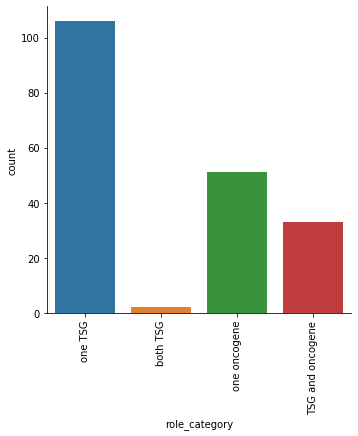

In [126]:
g = sns.catplot(x="role_category", kind="count", data=data)
g.set_xticklabels(rotation=90)

In [127]:
data['supporting_frags'] = data.spanning_reads + data.junction_reads
data.supporting_frags

2    193
3     13
4    123
6     33
7     13
    ... 
2      7
0     58
1     14
2      9
3      8
Name: supporting_frags, Length: 2191, dtype: int64

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

one TSG v.s. one oncogene: Mann-Whitney-Wilcoxon test two-sided P_val=5.822e-01 U_stat=2.556e+03


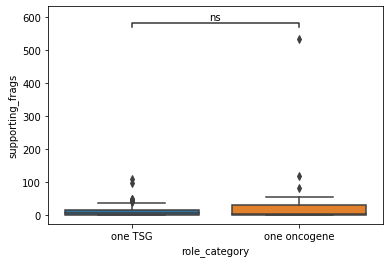

In [131]:
order = ['one TSG', 'one oncogene']
ax = sns.boxplot(x='role_category', y='supporting_frags', data=data, order=order)
test_results = add_stat_annotation(ax, data=data, x='role_category', y='supporting_frags', order=order,
                                   box_pairs=[('one TSG', 'one oncogene')],
                                   test='Mann-Whitney', text_format='star', verbose=2)